In [ ]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 125
LR = 5e-5 
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.1 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
feature_extractor = models.Classifier(in_shape=IN_SHAPE*N_MAG*MAGNIFICATION, in_channels=1).to(device)
truncated_weights = {}
for key,value in torch.load('Feature_weights.pt',weights_only=True).items():
    if not key.startswith('fc2'):
        truncated_weights[key] = value
feature_extractor.load_state_dict(truncated_weights)
feature_extractor.eval()
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, feature_extractor=feature_extractor, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.223153e6
Discriminator network 1 parameters: 0.069553e6
Discriminator network 2 parameters: 0.036785e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


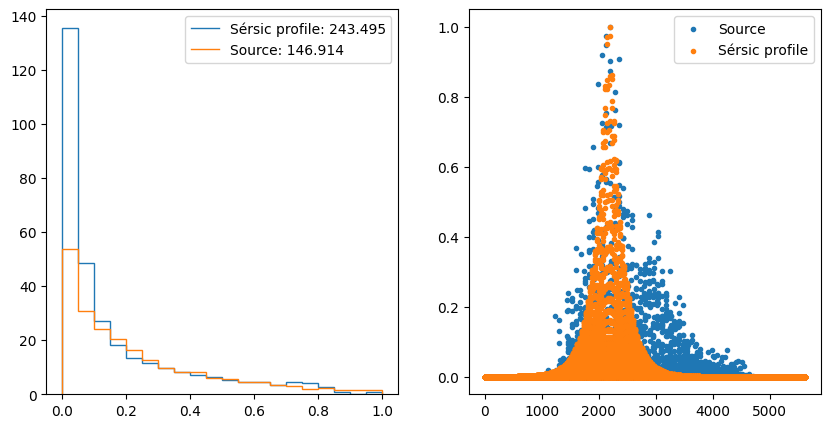

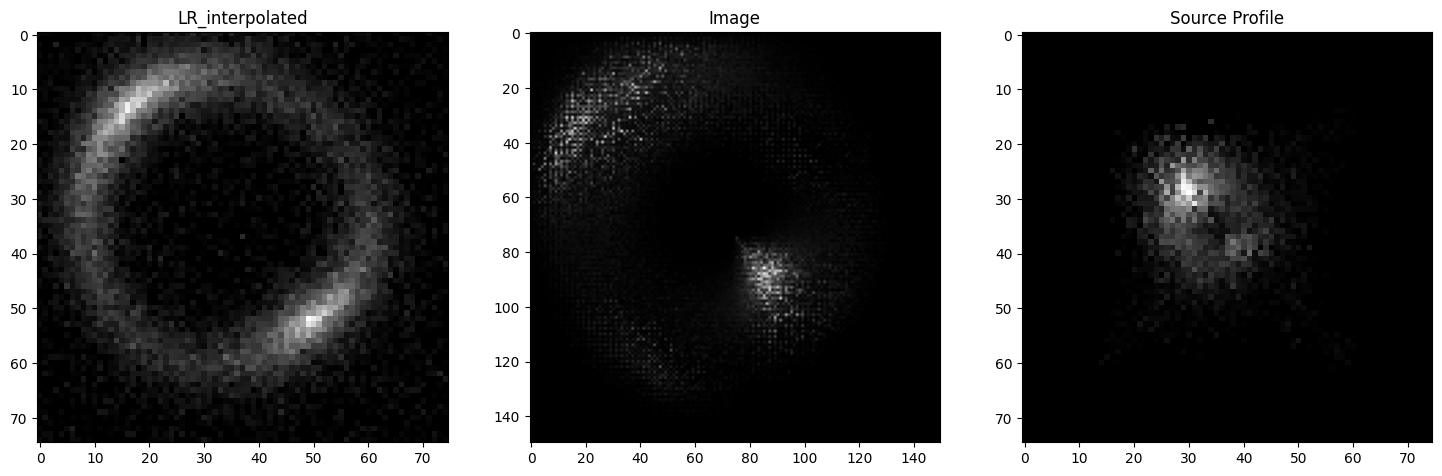

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 1/125: 0.02133802517246473 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 29.95it/s]


Validation at epoch 1/125: 0.015510415984774189 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [01:04<00:00, 12.66it/s]


Training at epoch 2/125: 0.013666345516457132 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 29.77it/s]


Validation at epoch 2/125: 0.012411916897833056 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [01:04<00:00, 12.63it/s]


Training at epoch 3/125: 0.012844956529614353 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 30.14it/s]


Validation at epoch 3/125: 0.014031823306212058 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 4/125: 0.012574855972642953 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 30.21it/s]


Validation at epoch 4/125: 0.013386160836043747 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 5/125: 0.01252446196460868 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 29.32it/s]


Validation at epoch 5/125: 0.01215242825542102 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 6/125: 0.012364572285721305 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 29.24it/s]


Validation at epoch 6/125: 0.012303134290656695 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 7/125: 0.012311662906380232 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 29.66it/s]


Validation at epoch 7/125: 0.013333974394139232 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 8/125: 0.012278586178510131 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 29.53it/s]


Validation at epoch 8/125: 0.012358957844816021 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 9/125: 0.012162091015317643 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 29.29it/s]


Validation at epoch 9/125: 0.012290717232983795 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 10/125: 0.01201954304569346 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 29.57it/s]


Validation at epoch 10/125: 0.012436407743485225 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [01:04<00:00, 12.63it/s]


Training at epoch 11/125: 0.0119386376483068 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 29.98it/s]


Validation at epoch 11/125: 0.012077573127873406 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [01:04<00:00, 12.57it/s]


Training at epoch 12/125: 0.011870518305216798 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 29.77it/s]


Validation at epoch 12/125: 0.011402974126623102 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [01:04<00:00, 12.57it/s]


Training at epoch 13/125: 0.011854943938113352 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 29.58it/s]


Validation at epoch 13/125: 0.011546623990950905 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 14/125: 0.011438699125303138 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 29.71it/s]


Validation at epoch 14/125: 0.011669475674245726 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 15/125: 0.011321015553988343 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 29.24it/s]


Validation at epoch 15/125: 0.011226553829414223 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 16/125: 0.01129758424619521 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 29.57it/s]


Validation at epoch 16/125: 0.011280502894021317 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [01:04<00:00, 12.63it/s]


Training at epoch 17/125: 0.011292350170882783 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 29.81it/s]


Validation at epoch 17/125: 0.01110910951426965 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 18/125: 0.011274180840700865 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:07<00:00, 28.97it/s]


Validation at epoch 18/125: 0.011377267544351827 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 19/125: 0.011296554098496963 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 29.88it/s]


Validation at epoch 19/125: 0.011187724012415856 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 20/125: 0.011209388653821638 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 20/125: 0.011266273191865241 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [01:04<00:00, 12.57it/s]


Training at epoch 21/125: 0.01117727065185118 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 29.28it/s]


Validation at epoch 21/125: 0.010980974561557649 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 22/125: 0.01101403008461228 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 29.58it/s]


Validation at epoch 22/125: 0.010900612653309579 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 23/125: 0.011012565938846605 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:06<00:00, 29.80it/s]


Validation at epoch 23/125: 0.010940452709202839 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 24/125: 0.011004066602468167 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:07<00:00, 28.92it/s]


Validation at epoch 24/125: 0.010969203997542625 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 25/125: 0.010841679649863234 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 29.66it/s]


Validation at epoch 25/125: 0.010583535015957393 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 26/125: 0.010721778062397077 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 29.38it/s]


Validation at epoch 26/125: 0.010388510122235553 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [01:05<00:00, 12.54it/s]


Training at epoch 27/125: 0.008695042552633323 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 27/125: 0.007657605206808441 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [01:04<00:00, 12.64it/s]


Training at epoch 28/125: 0.006867043483533267 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 29.27it/s]


Validation at epoch 28/125: 0.006659814514397807 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [01:05<00:00, 12.54it/s]


Training at epoch 29/125: 0.006491402300846804 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:06<00:00, 29.39it/s]


Validation at epoch 29/125: 0.00629247841596439 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 30/125: 0.006048336847087222 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 30/125: 0.006233019222432346 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 31/125: 0.005522395289553257 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 29.35it/s]


Validation at epoch 31/125: 0.005133168182938414 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [01:05<00:00, 12.55it/s]


Training at epoch 32/125: 0.0042004106936099775 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 29.49it/s]


Validation at epoch 32/125: 0.0030485614937360347 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 33/125: 0.00318717728941028 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 29.88it/s]


Validation at epoch 33/125: 0.002845886381692253 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 34/125: 0.0032344088092798426 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 29.75it/s]


Validation at epoch 34/125: 0.0035824612989695287 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 35/125: 0.0032752338955141765 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 29.72it/s]


Validation at epoch 35/125: 0.0034479867989669886 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [01:04<00:00, 12.55it/s]


Training at epoch 36/125: 0.0033201974290076415 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 29.44it/s]


Validation at epoch 36/125: 0.004031566096647806 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [01:04<00:00, 12.60it/s]


Training at epoch 37/125: 0.0034056267600046305 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 37/125: 0.0031010291741218753 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [01:04<00:00, 12.60it/s]


Training at epoch 38/125: 0.003399775528052095 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 29.69it/s]


Validation at epoch 38/125: 0.003965315229388401 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 39/125: 0.0034491096023653058 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 29.27it/s]


Validation at epoch 39/125: 0.003119132117432195 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 40/125: 0.0035108705362611493 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 29.65it/s]


Validation at epoch 40/125: 0.003691389937040524 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 41/125: 0.0035252493330250106 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 29.60it/s]


Validation at epoch 41/125: 0.003494873271419612 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 42/125: 0.0034746843313198544 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 29.33it/s]


Validation at epoch 42/125: 0.0035866703729683933 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 43/125: 0.0035160543601009788 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 29.34it/s]


Validation at epoch 43/125: 0.0034424388663062606 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 44/125: 0.003477475501491498 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 29.21it/s]


Validation at epoch 44/125: 0.0033334240609238963 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 45/125: 0.0035185685286099515 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 29.48it/s]


Validation at epoch 45/125: 0.0035776041144808734 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 46/125: 0.0036387757062780737 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 29.95it/s]


Validation at epoch 46/125: 0.0034388940065600408 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [01:04<00:00, 12.60it/s]


Training at epoch 47/125: 0.0035672157331218305 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 29.81it/s]


Validation at epoch 47/125: 0.003054372389705546 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 48/125: 0.0037138848431412966 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 29.46it/s]


Validation at epoch 48/125: 0.0033796458388393397 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 49/125: 0.003707975324508809 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 29.67it/s]


Validation at epoch 49/125: 0.003210625048214912 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 50/125: 0.003696065067564561 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 29.45it/s]


Validation at epoch 50/125: 0.0031682950265188568 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 51/125: 0.003817914289000185 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 29.33it/s]


Validation at epoch 51/125: 0.004097445793198787 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [01:05<00:00, 12.55it/s]


Training at epoch 52/125: 0.0036985814119950247 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 30.03it/s]


Validation at epoch 52/125: 0.0037116082073457533 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [01:04<00:00, 12.57it/s]


Training at epoch 53/125: 0.0037711445668666037 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 29.83it/s]


Validation at epoch 53/125: 0.0034545605727437177 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 54/125: 0.003900107767246179 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 29.18it/s]


Validation at epoch 54/125: 0.0034085337964129664 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [01:04<00:00, 12.60it/s]


Training at epoch 55/125: 0.004695183325477011 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 29.50it/s]


Validation at epoch 55/125: 0.0040436539162400035 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 56/125: 0.004035051506862682 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 29.51it/s]


Validation at epoch 56/125: 0.0039099097056725235 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 57/125: 0.0041166700331957025 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 29.41it/s]


Validation at epoch 57/125: 0.004293848486792972 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [01:05<00:00, 12.55it/s]


Training at epoch 58/125: 0.0042983415367095455 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 29.69it/s]


Validation at epoch 58/125: 0.004191368909660548 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 59/125: 0.0042583596741857105 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 29.34it/s]


Validation at epoch 59/125: 0.0040179138410238405 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [01:05<00:00, 12.55it/s]


Training at epoch 60/125: 0.00444807285552373 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 29.64it/s]


Validation at epoch 60/125: 0.003809419496760443 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 61/125: 0.004228113045267973 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 29.33it/s]


Validation at epoch 61/125: 0.004411111409746238 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [01:05<00:00, 12.54it/s]


Training at epoch 62/125: 0.004286620789963646 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 29.90it/s]


Validation at epoch 62/125: 0.004156916490376484 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [01:05<00:00, 12.54it/s]


Training at epoch 63/125: 0.004343966708106831 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:07<00:00, 28.99it/s]


Validation at epoch 63/125: 0.003997137351475163 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [01:05<00:00, 12.50it/s]


Training at epoch 64/125: 0.004478876252274038 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 29.62it/s]


Validation at epoch 64/125: 0.004704743615601567 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [01:05<00:00, 12.51it/s]


Training at epoch 65/125: 0.004300935525041531 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 29.58it/s]


Validation at epoch 65/125: 0.005513917312069395 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 66/125: 0.004347006454540236 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 29.39it/s]


Validation at epoch 66/125: 0.004842788972846214 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 67/125: 0.004572969000393784 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 29.92it/s]


Validation at epoch 67/125: 0.004367675658488902 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 68/125: 0.004682480307511629 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:07<00:00, 29.05it/s]


Validation at epoch 68/125: 0.004094419979510883 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [01:05<00:00, 12.50it/s]


Training at epoch 69/125: 0.004493625395904624 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 29.39it/s]


Validation at epoch 69/125: 0.0038772420787912174 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 70/125: 0.004451950811373678 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 29.56it/s]


Validation at epoch 70/125: 0.004069658732951924 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 71/125: 0.004643518728912835 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 29.54it/s]


Validation at epoch 71/125: 0.004001641006670623 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 72/125: 0.005061199598333355 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 29.45it/s]


Validation at epoch 72/125: 0.004351227275608336 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 73/125: 0.004855817636174228 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 29.37it/s]


Validation at epoch 73/125: 0.004449630793019691 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [01:04<00:00, 12.58it/s]


Training at epoch 74/125: 0.005021762602493754 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 29.53it/s]


Validation at epoch 74/125: 0.003984386095373125 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 75/125: 0.005160704002478537 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 29.53it/s]


Validation at epoch 75/125: 0.004626484350677963 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [01:05<00:00, 12.53it/s]


Training at epoch 76/125: 0.004744238428144194 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 29.26it/s]


Validation at epoch 76/125: 0.0033651599746828617 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [01:04<00:00, 12.64it/s]


Training at epoch 77/125: 0.0041500441639964625 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 29.91it/s]


Validation at epoch 77/125: 0.004264524696219608 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 78/125: 0.004787710350772649 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 29.75it/s]


Validation at epoch 78/125: 0.004245810573611023 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 79/125: 0.0051932668551957 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 29.27it/s]


Validation at epoch 79/125: 0.004134356018481662 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [01:05<00:00, 12.52it/s]


Training at epoch 80/125: 0.005072780235708456 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 30.01it/s]


Validation at epoch 80/125: 0.0035298113028027407 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 81/125: 0.003856723027825758 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 29.53it/s]


Validation at epoch 81/125: 0.0036113251942023294 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 82/125: 0.003870934766311228 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:07<00:00, 29.12it/s]


Validation at epoch 82/125: 0.003847489583017259 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [01:04<00:00, 12.62it/s]


Training at epoch 83/125: 0.00405147166888948 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 29.25it/s]


Validation at epoch 83/125: 0.004381478888093375 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [01:04<00:00, 12.60it/s]


Training at epoch 84/125: 0.004505344895180457 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 29.77it/s]


Validation at epoch 84/125: 0.00441893241005863 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [01:05<00:00, 12.55it/s]


Training at epoch 85/125: 0.004608982124320355 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 29.28it/s]


Validation at epoch 85/125: 0.00467322909525155 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [01:04<00:00, 12.61it/s]


Training at epoch 86/125: 0.003835552576887974 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 29.55it/s]


Validation at epoch 86/125: 0.003939845855889942 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [01:04<00:00, 12.65it/s]


Training at epoch 87/125: 0.004605370343588398 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 29.52it/s]


Validation at epoch 87/125: 0.004183874136680399 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 88/125: 0.004599647354659871 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 29.35it/s]


Validation at epoch 88/125: 0.004607768613627117 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [01:04<00:00, 12.59it/s]


Training at epoch 89/125: 0.005379994011509195 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:07<00:00, 29.08it/s]


Validation at epoch 89/125: 0.004154009817427197 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [01:04<00:00, 12.64it/s]


Training at epoch 90/125: 0.004830999224948613 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 29.82it/s]


Validation at epoch 90/125: 0.004015338135835847 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 91/125: 0.0048521775629256705 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 29.38it/s]


Validation at epoch 91/125: 0.007051637356127292 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [01:04<00:00, 12.56it/s]


Training at epoch 92/125: 0.004869305555521529 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 29.62it/s]


Validation at epoch 92/125: 0.005240556676689462 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [01:05<00:00, 12.49it/s]


Training at epoch 93/125: 0.005395588994681877 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 29.86it/s]


Validation at epoch 93/125: 0.0063534047305937764 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [01:04<00:00, 12.64it/s]


Training at epoch 94/125: 0.004416398604739588 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 29.22it/s]


Validation at epoch 94/125: 0.0026317432971310673 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [01:04<00:00, 12.69it/s]


Training at epoch 95/125: 0.0025657190225421207 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 29.41it/s]


Validation at epoch 95/125: 0.0026212613173650905 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [01:04<00:00, 12.66it/s]


Training at epoch 96/125: 0.0025652915019058055 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 29.61it/s]


Validation at epoch 96/125: 0.0026242845005803174 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [01:04<00:00, 12.64it/s]


Training at epoch 97/125: 0.002571544190811669 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 29.19it/s]


Validation at epoch 97/125: 0.0026312107796662067 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [01:04<00:00, 12.70it/s]


Training at epoch 98/125: 0.0025780653792453986 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 29.20it/s]


Validation at epoch 98/125: 0.0026386086988792407 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [01:04<00:00, 12.67it/s]


Training at epoch 99/125: 0.0025760772154100387 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 29.16it/s]


Validation at epoch 99/125: 0.002641286902408134 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [01:05<00:00, 12.51it/s]


Training at epoch 100/125: 0.0025763198721631174 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:07<00:00, 27.34it/s]


Validation at epoch 100/125: 0.0026300329442236424 at LR=5e-05


Training epoch 101: 100%|██████████| 816/816 [01:06<00:00, 12.32it/s]


Training at epoch 101/125: 0.0025734062127965303 at LR=5e-05


Validation epoch 101: 100%|██████████| 204/204 [00:07<00:00, 28.36it/s]


Validation at epoch 101/125: 0.002623887870154873 at LR=5e-05


Training epoch 102: 100%|██████████| 816/816 [01:06<00:00, 12.20it/s]


Training at epoch 102/125: 0.002580105827256179 at LR=5e-05


Validation epoch 102: 100%|██████████| 204/204 [00:07<00:00, 28.03it/s]


Validation at epoch 102/125: 0.0026291190377235704 at LR=5e-05


Training epoch 103: 100%|██████████| 816/816 [01:06<00:00, 12.27it/s]


Training at epoch 103/125: 0.002579177963472081 at LR=5e-05


Validation epoch 103: 100%|██████████| 204/204 [00:07<00:00, 28.56it/s]


Validation at epoch 103/125: 0.002650763895978932 at LR=5e-05


Training epoch 104: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 104/125: 0.0025779481612855804 at LR=5e-05


Validation epoch 104: 100%|██████████| 204/204 [00:07<00:00, 27.74it/s]


Validation at epoch 104/125: 0.0026314954191227168 at LR=5e-05


Training epoch 105: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 105/125: 0.0025798177652462733 at LR=5e-05


Validation epoch 105: 100%|██████████| 204/204 [00:07<00:00, 27.52it/s]


Validation at epoch 105/125: 0.002624001175932148 at LR=5e-05


Training epoch 106: 100%|██████████| 816/816 [01:07<00:00, 12.09it/s]


Training at epoch 106/125: 0.002577301918505577 at LR=5e-05


Validation epoch 106: 100%|██████████| 204/204 [00:07<00:00, 26.94it/s]


Validation at epoch 106/125: 0.0026442381552210553 at LR=5e-05


Training epoch 107: 100%|██████████| 816/816 [01:07<00:00, 12.06it/s]


Training at epoch 107/125: 0.002579329391129945 at LR=5e-05


Validation epoch 107: 100%|██████████| 204/204 [00:07<00:00, 27.82it/s]


Validation at epoch 107/125: 0.0026242613835789847 at LR=5e-05


Training epoch 108: 100%|██████████| 816/816 [01:06<00:00, 12.29it/s]


Training at epoch 108/125: 0.0025801466653516112 at LR=5e-05


Validation epoch 108: 100%|██████████| 204/204 [00:07<00:00, 28.64it/s]


Validation at epoch 108/125: 0.00263041129915555 at LR=5e-05


Training epoch 109: 100%|██████████| 816/816 [01:06<00:00, 12.30it/s]


Training at epoch 109/125: 0.0025753935904004703 at LR=5e-05


Validation epoch 109: 100%|██████████| 204/204 [00:07<00:00, 28.42it/s]


Validation at epoch 109/125: 0.002622357149056031 at LR=5e-05


Training epoch 110: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 110/125: 0.0025782313546811814 at LR=5e-05


Validation epoch 110: 100%|██████████| 204/204 [00:07<00:00, 28.47it/s]


Validation at epoch 110/125: 0.002630870626650422 at LR=5e-05


Training epoch 111: 100%|██████████| 816/816 [01:06<00:00, 12.36it/s]


Training at epoch 111/125: 0.0025751603822630155 at LR=5e-05


Validation epoch 111: 100%|██████████| 204/204 [00:07<00:00, 28.63it/s]


Validation at epoch 111/125: 0.0026249463981537916 at LR=5e-05


Training epoch 112: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 112/125: 0.002579262013765116 at LR=5e-05


Validation epoch 112: 100%|██████████| 204/204 [00:07<00:00, 28.28it/s]


Validation at epoch 112/125: 0.002623391617888439 at LR=5e-05


Training epoch 113: 100%|██████████| 816/816 [01:06<00:00, 12.29it/s]


Training at epoch 113/125: 0.002574251708032463 at LR=5e-05


Validation epoch 113: 100%|██████████| 204/204 [00:07<00:00, 27.80it/s]


Validation at epoch 113/125: 0.002627192667740233 at LR=5e-05


Training epoch 114: 100%|██████████| 816/816 [01:07<00:00, 12.13it/s]


Training at epoch 114/125: 0.0025795591488941665 at LR=5e-05


Validation epoch 114: 100%|██████████| 204/204 [00:07<00:00, 28.36it/s]


Validation at epoch 114/125: 0.002640904517451703 at LR=5e-05


Training epoch 115: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 115/125: 0.002574475464700977 at LR=5e-05


Validation epoch 115: 100%|██████████| 204/204 [00:07<00:00, 28.17it/s]


Validation at epoch 115/125: 0.0026241813343493084 at LR=5e-05


Training epoch 116: 100%|██████████| 816/816 [01:05<00:00, 12.37it/s]


Training at epoch 116/125: 0.0025802218117271826 at LR=5e-05


Validation epoch 116: 100%|██████████| 204/204 [00:07<00:00, 27.93it/s]


Validation at epoch 116/125: 0.002624579663639523 at LR=5e-05


Training epoch 117: 100%|██████████| 816/816 [01:05<00:00, 12.40it/s]


Training at epoch 117/125: 0.0025782612174938837 at LR=5e-05


Validation epoch 117: 100%|██████████| 204/204 [00:07<00:00, 28.50it/s]


Validation at epoch 117/125: 0.0026253714322057716 at LR=5e-05


Training epoch 118: 100%|██████████| 816/816 [01:06<00:00, 12.35it/s]


Training at epoch 118/125: 0.0025758957453231855 at LR=5e-05


Validation epoch 118: 100%|██████████| 204/204 [00:07<00:00, 28.40it/s]


Validation at epoch 118/125: 0.0026615268434397876 at LR=5e-05


Training epoch 119: 100%|██████████| 816/816 [01:06<00:00, 12.28it/s]


Training at epoch 119/125: 0.0025784202997444893 at LR=5e-05


Validation epoch 119: 100%|██████████| 204/204 [00:07<00:00, 28.34it/s]


Validation at epoch 119/125: 0.0026401535125093207 at LR=5e-05


Training epoch 120: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 120/125: 0.0025776556157164603 at LR=5e-05


Validation epoch 120: 100%|██████████| 204/204 [00:07<00:00, 28.28it/s]


Validation at epoch 120/125: 0.002629425004581172 at LR=5e-05


Training epoch 121: 100%|██████████| 816/816 [01:05<00:00, 12.41it/s]


Training at epoch 121/125: 0.002576535103406629 at LR=5e-05


Validation epoch 121: 100%|██████████| 204/204 [00:07<00:00, 28.67it/s]


Validation at epoch 121/125: 0.0026248689032132354 at LR=5e-05


Training epoch 122: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 122/125: 0.002573879159600063 at LR=5e-05


Validation epoch 122: 100%|██████████| 204/204 [00:07<00:00, 28.62it/s]


Validation at epoch 122/125: 0.002638907107871537 at LR=5e-05


Training epoch 123: 100%|██████████| 816/816 [01:06<00:00, 12.31it/s]


Training at epoch 123/125: 0.0025768596539159725 at LR=5e-05


Validation epoch 123: 100%|██████████| 204/204 [00:07<00:00, 28.86it/s]


Validation at epoch 123/125: 0.0026215716195521037 at LR=5e-05


Training epoch 124: 100%|██████████| 816/816 [01:05<00:00, 12.38it/s]


Training at epoch 124/125: 0.002579698906914678 at LR=5e-05


Validation epoch 124: 100%|██████████| 204/204 [00:07<00:00, 28.80it/s]


Validation at epoch 124/125: 0.00262237515177249 at LR=5e-05


Training epoch 125: 100%|██████████| 816/816 [01:06<00:00, 12.33it/s]


Training at epoch 125/125: 0.0025777503769324325 at LR=5e-05


Validation epoch 125: 100%|██████████| 204/204 [00:07<00:00, 27.83it/s]


Validation at epoch 125/125: 0.0026279929420435985 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

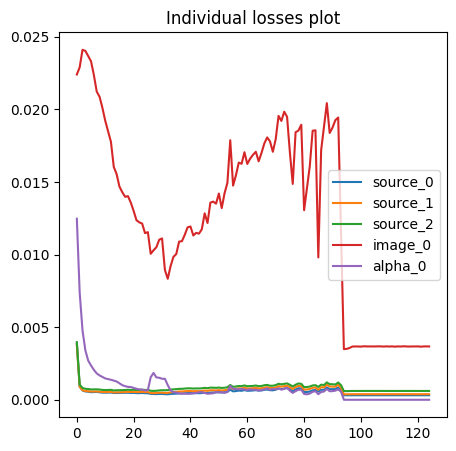

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

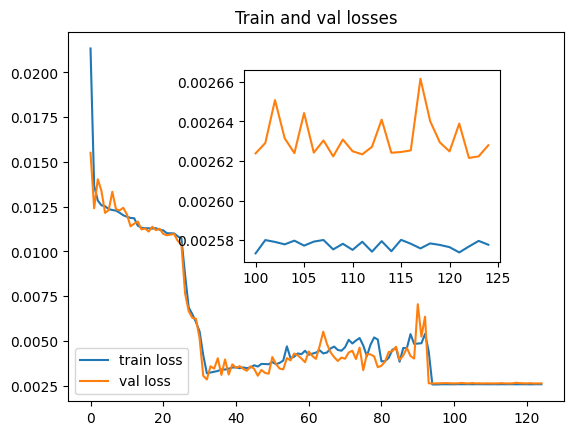

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.0026212613173650905


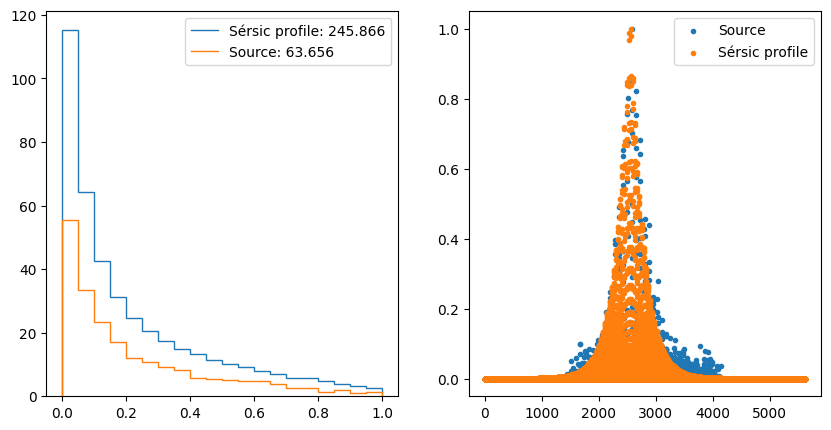

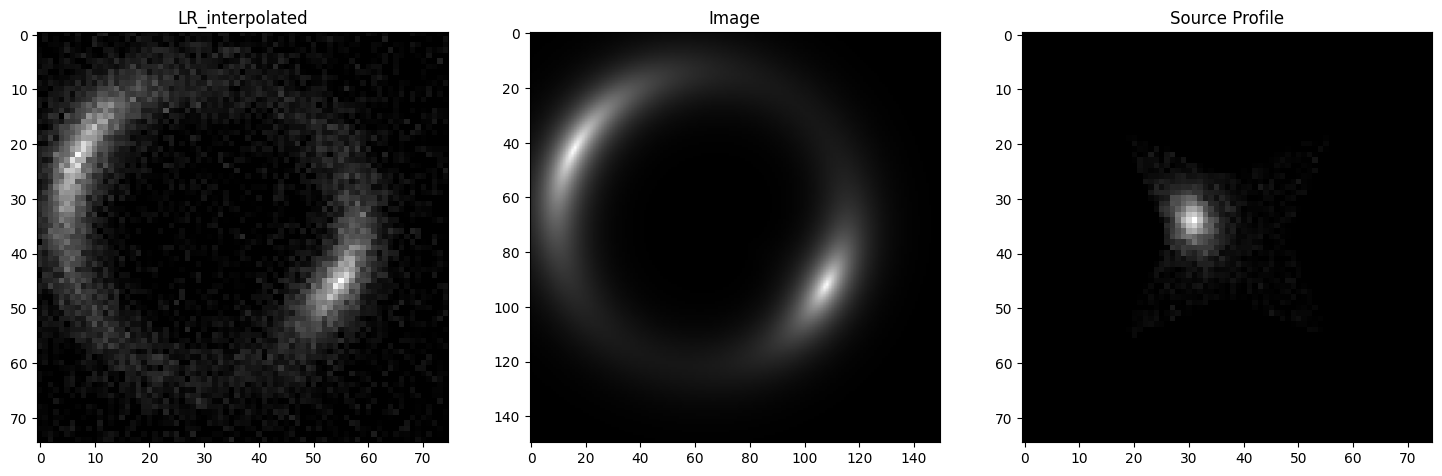

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_1.pt')